# SMS 

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import IPython.display as ipd
import librosa, librosa.display
import soundfile as sf

In [2]:
wav_file_path = os.path.join('test_trajectories','guccini_vocals.wav')
x, Fs = librosa.load(wav_file_path)

![analysis scheme](./test_trajectories/pic_an.png "Analysis")

![synthesis scheme](./test_trajectories/pic_syn.png "Synthesis")

In [3]:
def detectPeaks(signalFFT):
    # Find peaks
    peaks = librosa.util.peak_pick(x=signalFFT, pre_max=3, post_max=3, pre_avg=3, 
            post_avg=5, delta=0.7, wait=10)
    return peaks

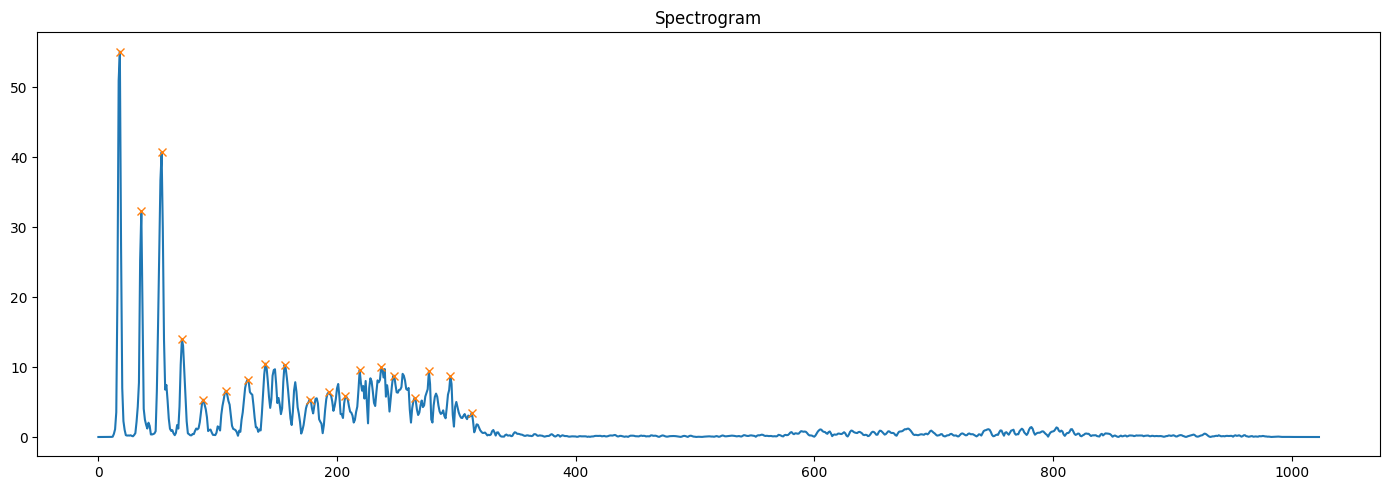

[ 18.  36.  53.  70.  88. 107. 125. 140. 156. 177. 193. 207. 219. 237.
 248. 265. 277. 295. 313.]


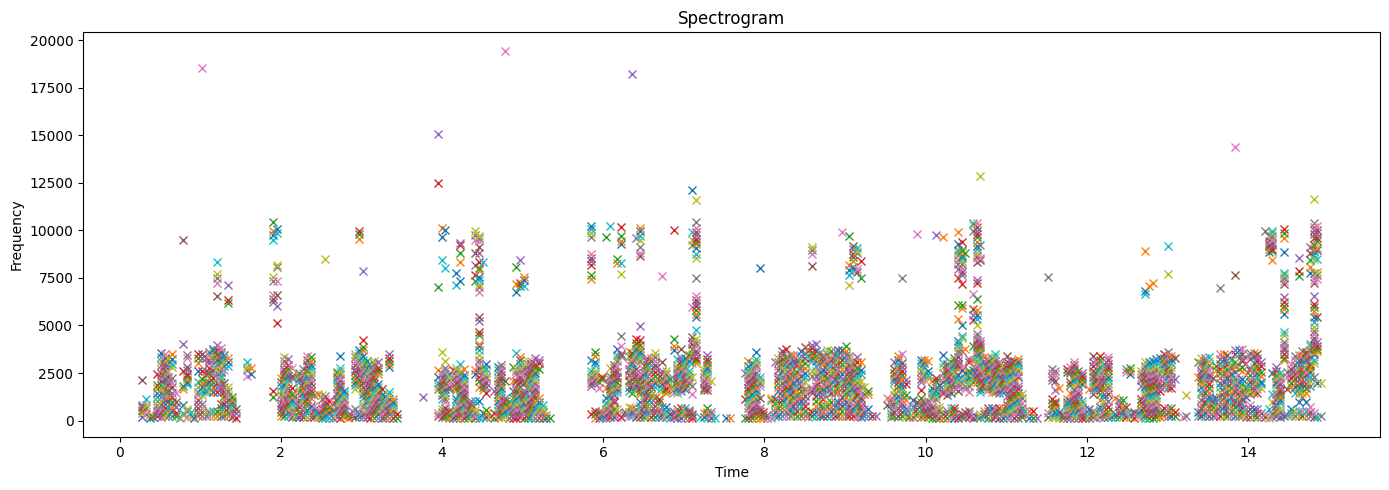

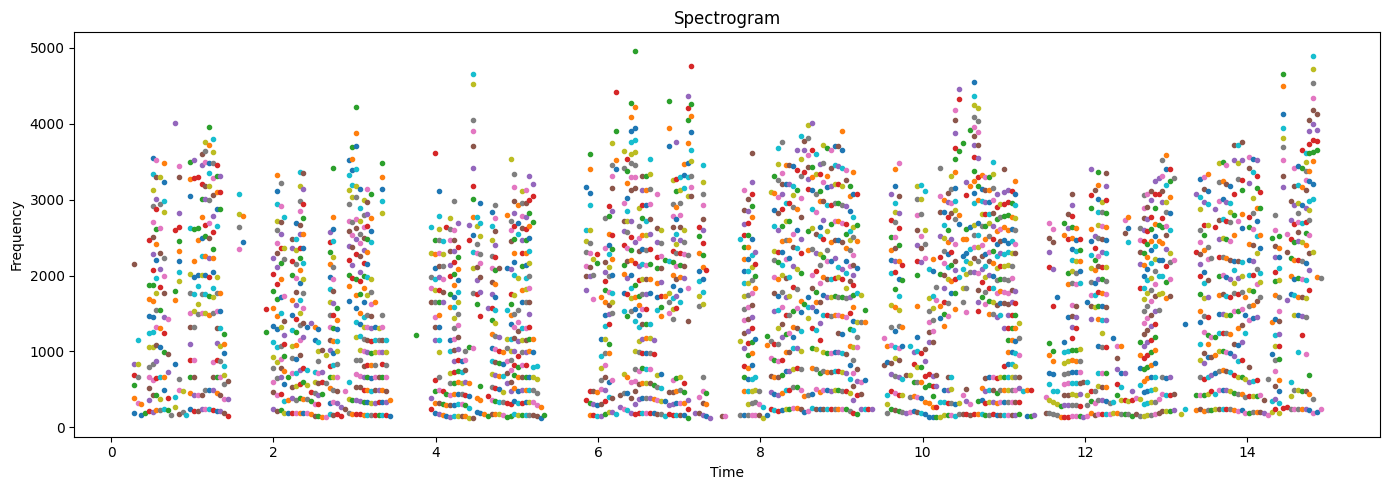

[0. 0. 0. ... 0. 0. 0.]


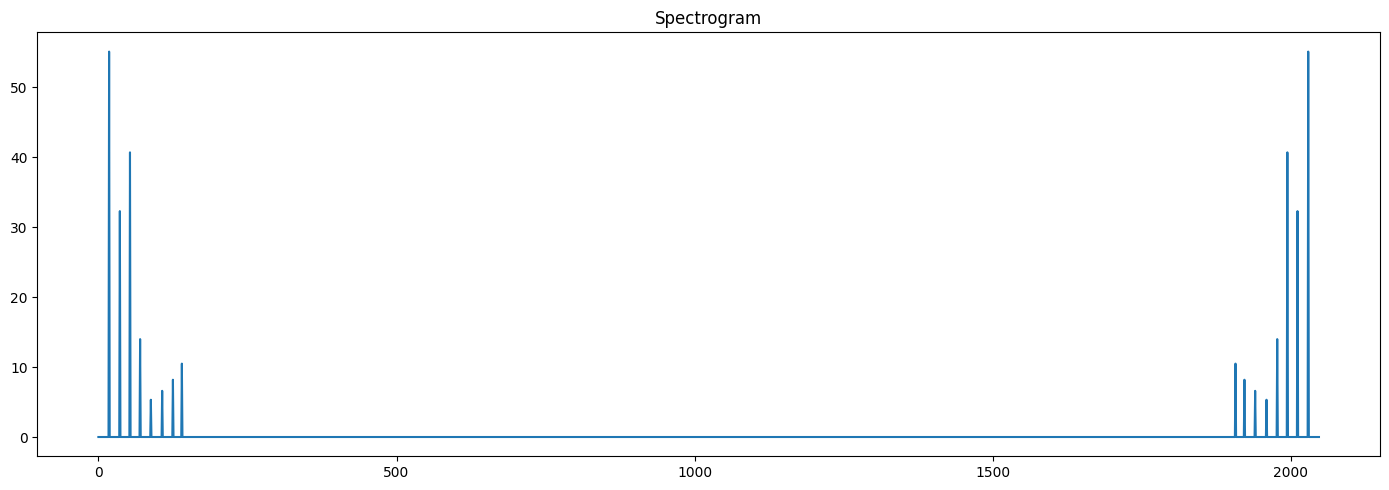

[0.16855564+0.j         0.1653598 -0.00025366j 0.15611268-0.00047895j ...
 0.1417854 +0.00065249j 0.15611268+0.00047895j 0.1653598 +0.00025366j]


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

In [30]:
#SMS
#extract a 15 second excerpt from the middle of the song


x1 = x[15*Fs:30*Fs]
L = len(x1)
h = 1024
w = 2048
win = np.hanning(w)

frames = {}
freq_traj = {}
ampl_traj = {}
spec_env = {}
i = 0
n = 0
#so the idea is we windows frames then follow the scheme
while(i+w<L):
    frame = x1[i:i+w] * win
    i = i + h
    frames[n] = frame * win
    n+=1

#last frame: zero pad
frame = x1[i:]
pad_L = w - len(frame)
frame = np.pad(frame, (0,pad_L), 'constant', constant_values=(0, 0))
frame *= win
frames[n] = frame 
#substitute each frame with its spectrum
for i in range(n+1):
    frames[i] = np.abs(np.fft.fft(frames[i]))
f_rescale_factor = Fs/w
t_rescale_factor = h/Fs
#display an example
pks = detectPeaks(frames[50])
plt.figure(figsize=(14, 5))
plt.plot(frames[50][:math.floor(w/2)])
pks = pks[:math.floor(len(pks)/2)]

plt.plot(pks, frames[50][pks], 'x')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

#save peak locationa nd info
peaks = {}
for i in range(n+1):
    pk_loc = detectPeaks(frames[i])
    pk_loc = pk_loc[:math.floor(len(pk_loc)/2)]
    pk_amp = []
    for j in range(len(pk_loc)):
        pk_amp.append(frames[i][pk_loc[j]])
    if(len(pk_loc) != 0):
        peaks[i] = np.array([pk_loc, pk_amp])
    else:
        peaks[i] = np.array([[],[]])
print(peaks[50][0])

#plot a representation of peaks as dots in a time vs frequency representation
plt.figure(figsize=(14, 5))
for i in range(n+1):
    if(len(peaks[i][0])!=0):
        curr_peak_loc = peaks[i][0]
        for j in range(len(curr_peak_loc)):
            plt.plot(i*t_rescale_factor, curr_peak_loc[j]*f_rescale_factor, 'x')
plt.title('Spectrogram')
#the x axis is time, the y axis frequency
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#it's time to refine the results
#remove outliers (f>5000Hz)
for i in range(n+1):
    if(len(peaks[i][0])!=0):
        arr = peaks[i][0][peaks[i][0]<(5000/f_rescale_factor)]
        peaks[i][0][len(arr):len(peaks[i][0])] = 0

#represent them again
plt.figure(figsize=(14, 5))
for i in range(n+1):
    if(len(peaks[i][0])!=0):
        curr_peak_loc = peaks[i][0]
        for j in range(len(curr_peak_loc)):
            if(curr_peak_loc[j]!=0):
                plt.plot(i*t_rescale_factor, curr_peak_loc[j]*f_rescale_factor, '.')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#let's get a frequency representation of these peaks
#we use 8 sines, each located at a peak
#TODO: change this so that you build in frequency then do ifft
add_frame  = {}
for i in range(n+1):
    if(len(peaks[i][0])!=0):
        curr_peak_loc = peaks[i][0]
        curr_peak_amp = peaks[i][1]
        new_frame = np.zeros(int(w/2))

        for j in range(min(len(curr_peak_loc),8)):
            if(curr_peak_loc[j]!=0):
                #add a sine wave
                new_frame[int(curr_peak_loc[j])] = curr_peak_amp[j]
        new_frame = np.concatenate((new_frame, np.flip(new_frame)))
        add_frame[i] = new_frame

print(add_frame[50])

#plot add_frame[50]
plt.figure(figsize=(14, 5))
plt.plot(add_frame[50])
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


for i in range(n+1):
    if i in add_frame:
        add_frame[i] = np.fft.ifft(add_frame[i])

print(add_frame[50])

#overlap and add the frames
#we use a hanning window to smooth the transition
final_signal = np.zeros((n+5)*h)
for i in range(n+1):
    if(i in add_frame):
        final_signal[i*h:i*h+w] += add_frame[i]*win
#normalise
#final_signal /= np.max(final_signal)
#export the final signal
sf.write('sines_only.wav', final_signal, Fs, subtype='PCM_24')

#so now we have the reconstructed sines signal.

In [28]:
err_frame = {}
for i in range(n+1):
    if i in add_frame:
        err_frame[i] = frames[i] - add_frame[i]


#overlap and add the frames
#we use a hanning window to smooth the transition
final_signal = np.zeros((n+5)*h)
for i in range(n+1):
    if(i in add_frame):
        final_signal[i*h:i*h+w] += np.fft.ifft(err_frame[i])*win
#normalise
#final_signal /= np.max(final_signal)
#export the final signal
sf.write('sines_only.wav', final_signal, Fs, subtype='PCM_24')

#so now we have the reconstructed sines signal.

330750
333824


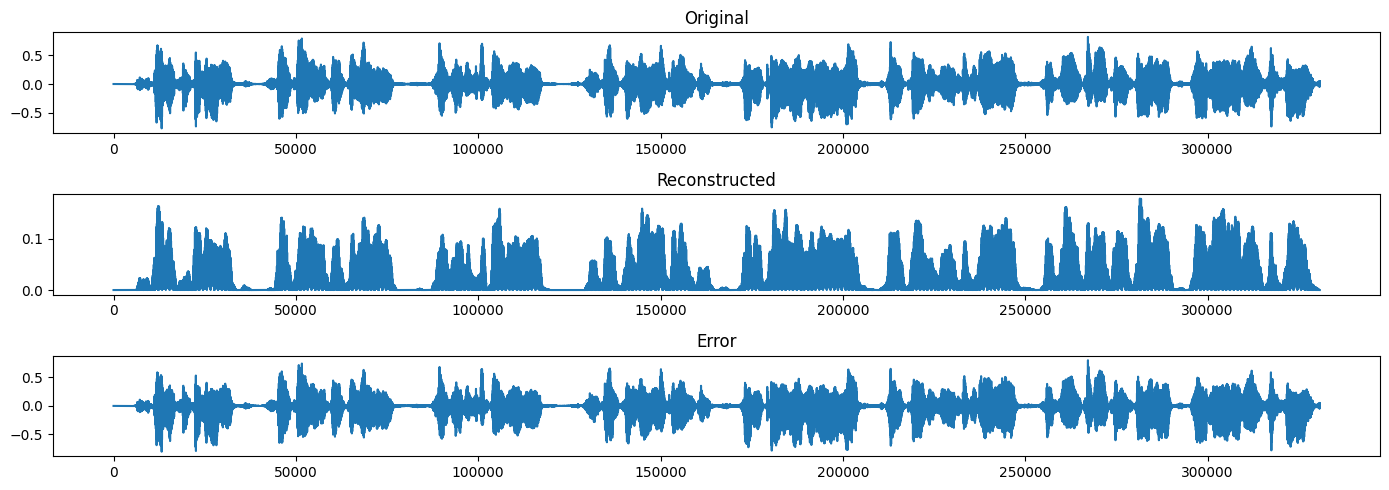

In [17]:
#let's subtract the reconstructed from the original and hear how it sounds
print(len(x1))
print(len(final_signal))
arr2 = final_signal[0:len(x1)]

err = x1 - arr2
#display x1,arr2 and err in 3 subplots
plt.figure(figsize=(14, 5))
plt.subplot(3,1,1)
plt.plot(x1)
plt.title('Original')
plt.subplot(3,1,2)
plt.plot(arr2)
plt.title('Reconstructed')
plt.subplot(3,1,3)
plt.plot(err)
plt.title('Error')
plt.tight_layout()
plt.show()

sf.write('error.wav', err, Fs, subtype='PCM_24')

In [ ]:

#here comes the split
peaks_frame = {}
for i in range(n+1):
    peaks_frame[i] = detectPeaks(frames[i])

